In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time
import pyabc 
from datetime import timedelta
# Set seed
np.random.seed(42)
import elfi
# Simulation parameters
N_AUDIENCES = 10  # Number of unique audience members
OBS_PER_AUDIENCE = 8  # Observations per audience member

# True hyperparameters
hyper_mu_intercept = 2.0    # Population-level intercept
hyper_sigma_intercept = 0.5 # Between-audience intercept variability
hyper_mu_slope = -0.03      # Population-level cost slope 
hyper_sigma_slope = 0.01    # Between-audience slope variability

# Simulate audience-specific parameters
audience_ids = np.repeat(np.arange(N_AUDIENCES), OBS_PER_AUDIENCE)
true_intercepts = np.random.normal(hyper_mu_intercept, hyper_sigma_intercept, N_AUDIENCES)
true_slopes = np.random.normal(hyper_mu_slope, hyper_sigma_slope, N_AUDIENCES)

# Simulate cost and clicks
cost = np.random.gamma(shape=5, scale=1, size=N_AUDIENCES*OBS_PER_AUDIENCE)
eta = true_intercepts[audience_ids] + true_slopes[audience_ids] * cost
clicks = np.random.poisson(lam=np.exp(eta))

# Create DataFrame
data = pd.DataFrame({
    "audience_id": audience_ids,
    "cost": cost,
    "clicks": clicks
})
data

,audience_id,cost,clicks
0,0,8.602851,5
1,0,4.195728,3
2,0,3.586684,12
3,0,4.910412,11
4,0,3.485679,8
...,...,...,...
75,9,5.076993,7
76,9,5.250892,7
77,9,6.567539,6
78,9,5.887435,12


In [2]:
distributions = dict(
    mu_intercept = elfi.Prior("norm", 0, 2),
    sigma_intercept = elfi.Prior("halfnorm", 0, 0.5),
    mu_slope = elfi.Prior("norm", 0, 0.1),
    sigma_slope = elfi.Prior("halfnorm", 0, 0.5), 
)

for i in range(N_AUDIENCES):
    distributions[f"alpha_z_{i}"] = elfi.Prior("norm", 0, 1)
    distributions[f"beta_z{i}"] = elfi.Prior("norm", 0, 1)

priors = list(distributions.values())
priors

[Prior(name='mu_intercept', 'norm'),
 Prior(name='sigma_intercept', 'halfnorm'),
 Prior(name='mu_slope', 'norm'),
 Prior(name='sigma_slope', 'halfnorm'),
 Prior(name='_prior_7e08', 'norm'),
 Prior(name='_prior_6c11', 'norm'),
 Prior(name='_prior_3a64', 'norm'),
 Prior(name='_prior_fb7e', 'norm'),
 Prior(name='_prior_9955', 'norm'),
 Prior(name='_prior_dcc0', 'norm'),
 Prior(name='_prior_9a89', 'norm'),
 Prior(name='_prior_f7b3', 'norm'),
 Prior(name='_prior_40a1', 'norm'),
 Prior(name='_prior_2909', 'norm'),
 Prior(name='_prior_31e2', 'norm'),
 Prior(name='_prior_8d10', 'norm'),
 Prior(name='_prior_1062', 'norm'),
 Prior(name='_prior_abe6', 'norm'),
 Prior(name='_prior_67d3', 'norm'),
 Prior(name='_prior_bb5a', 'norm'),
 Prior(name='_prior_4b95', 'norm'),
 Prior(name='_prior_14c4', 'norm'),
 Prior(name='_prior_e3bc', 'norm'),
 Prior(name='_prior_021d', 'norm')]

In [3]:
from scipy.stats import wasserstein_distance

def simulator_func(
    *parameter_values: list,
    size: int | None = None,
    batch_size: int = 1,
    random_state: int | None = None,
):
    parameters = {}
    for i, parameter_name in enumerate(distributions):
        parameters[parameter_name] = parameter_values[i].item()

    audience_ids = data.audience_id
    cost = data.cost
    observed_clicks = data.clicks.values
    
    alpha_z = []
    beta_z = []
    for i in range(N_AUDIENCES):
        alpha_z.append(parameters[f"alpha_z_{i}"])
        beta_z.append(parameters[f"beta_z{i}"])
    alpha_z = np.array(alpha_z)
    beta_z = np.array(beta_z)

    alpha = parameters["mu_intercept"] + alpha_z[audience_ids] * parameters["sigma_intercept"]
    beta = parameters["mu_slope"] + beta_z[audience_ids] * parameters["sigma_slope"]

    eta = alpha[audience_ids] + beta[audience_ids]*cost
    eta = eta.astype(np.float64)
    lam = np.exp(eta)
    lam[lam > 50] = 50
    simulated_clicks = np.random.poisson(lam=lam)

    discrepancy = wasserstein_distance(simulated_clicks, observed_clicks)
    return [discrepancy]

simulator = elfi.Simulator(
    simulator_func,
    *priors,
    observed=data.clicks.values,
    name="simulator",
)

identity_statistic = elfi.Summary(
    lambda y: y, simulator, name="identity_statistic"
)

distance = elfi.Distance(
    lambda simulated, _: simulated, identity_statistic, name="identity_distance"
)

sampler = elfi.AdaptiveThresholdSMC(distance, batch_size=1, seed=42)

In [4]:
sampler.bar = True
sampler.set_objective(100, max_iter=3)
walltime = time.time() + 3 * 60

while not sampler.finished and time.time() < walltime:
    sampler.iterate()

ABC-SMC Round 1 / 3
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 3


Could not estimate the sample covariance. This is often caused by majority of the sample weights becoming zero.Falling back to using unit covariance.


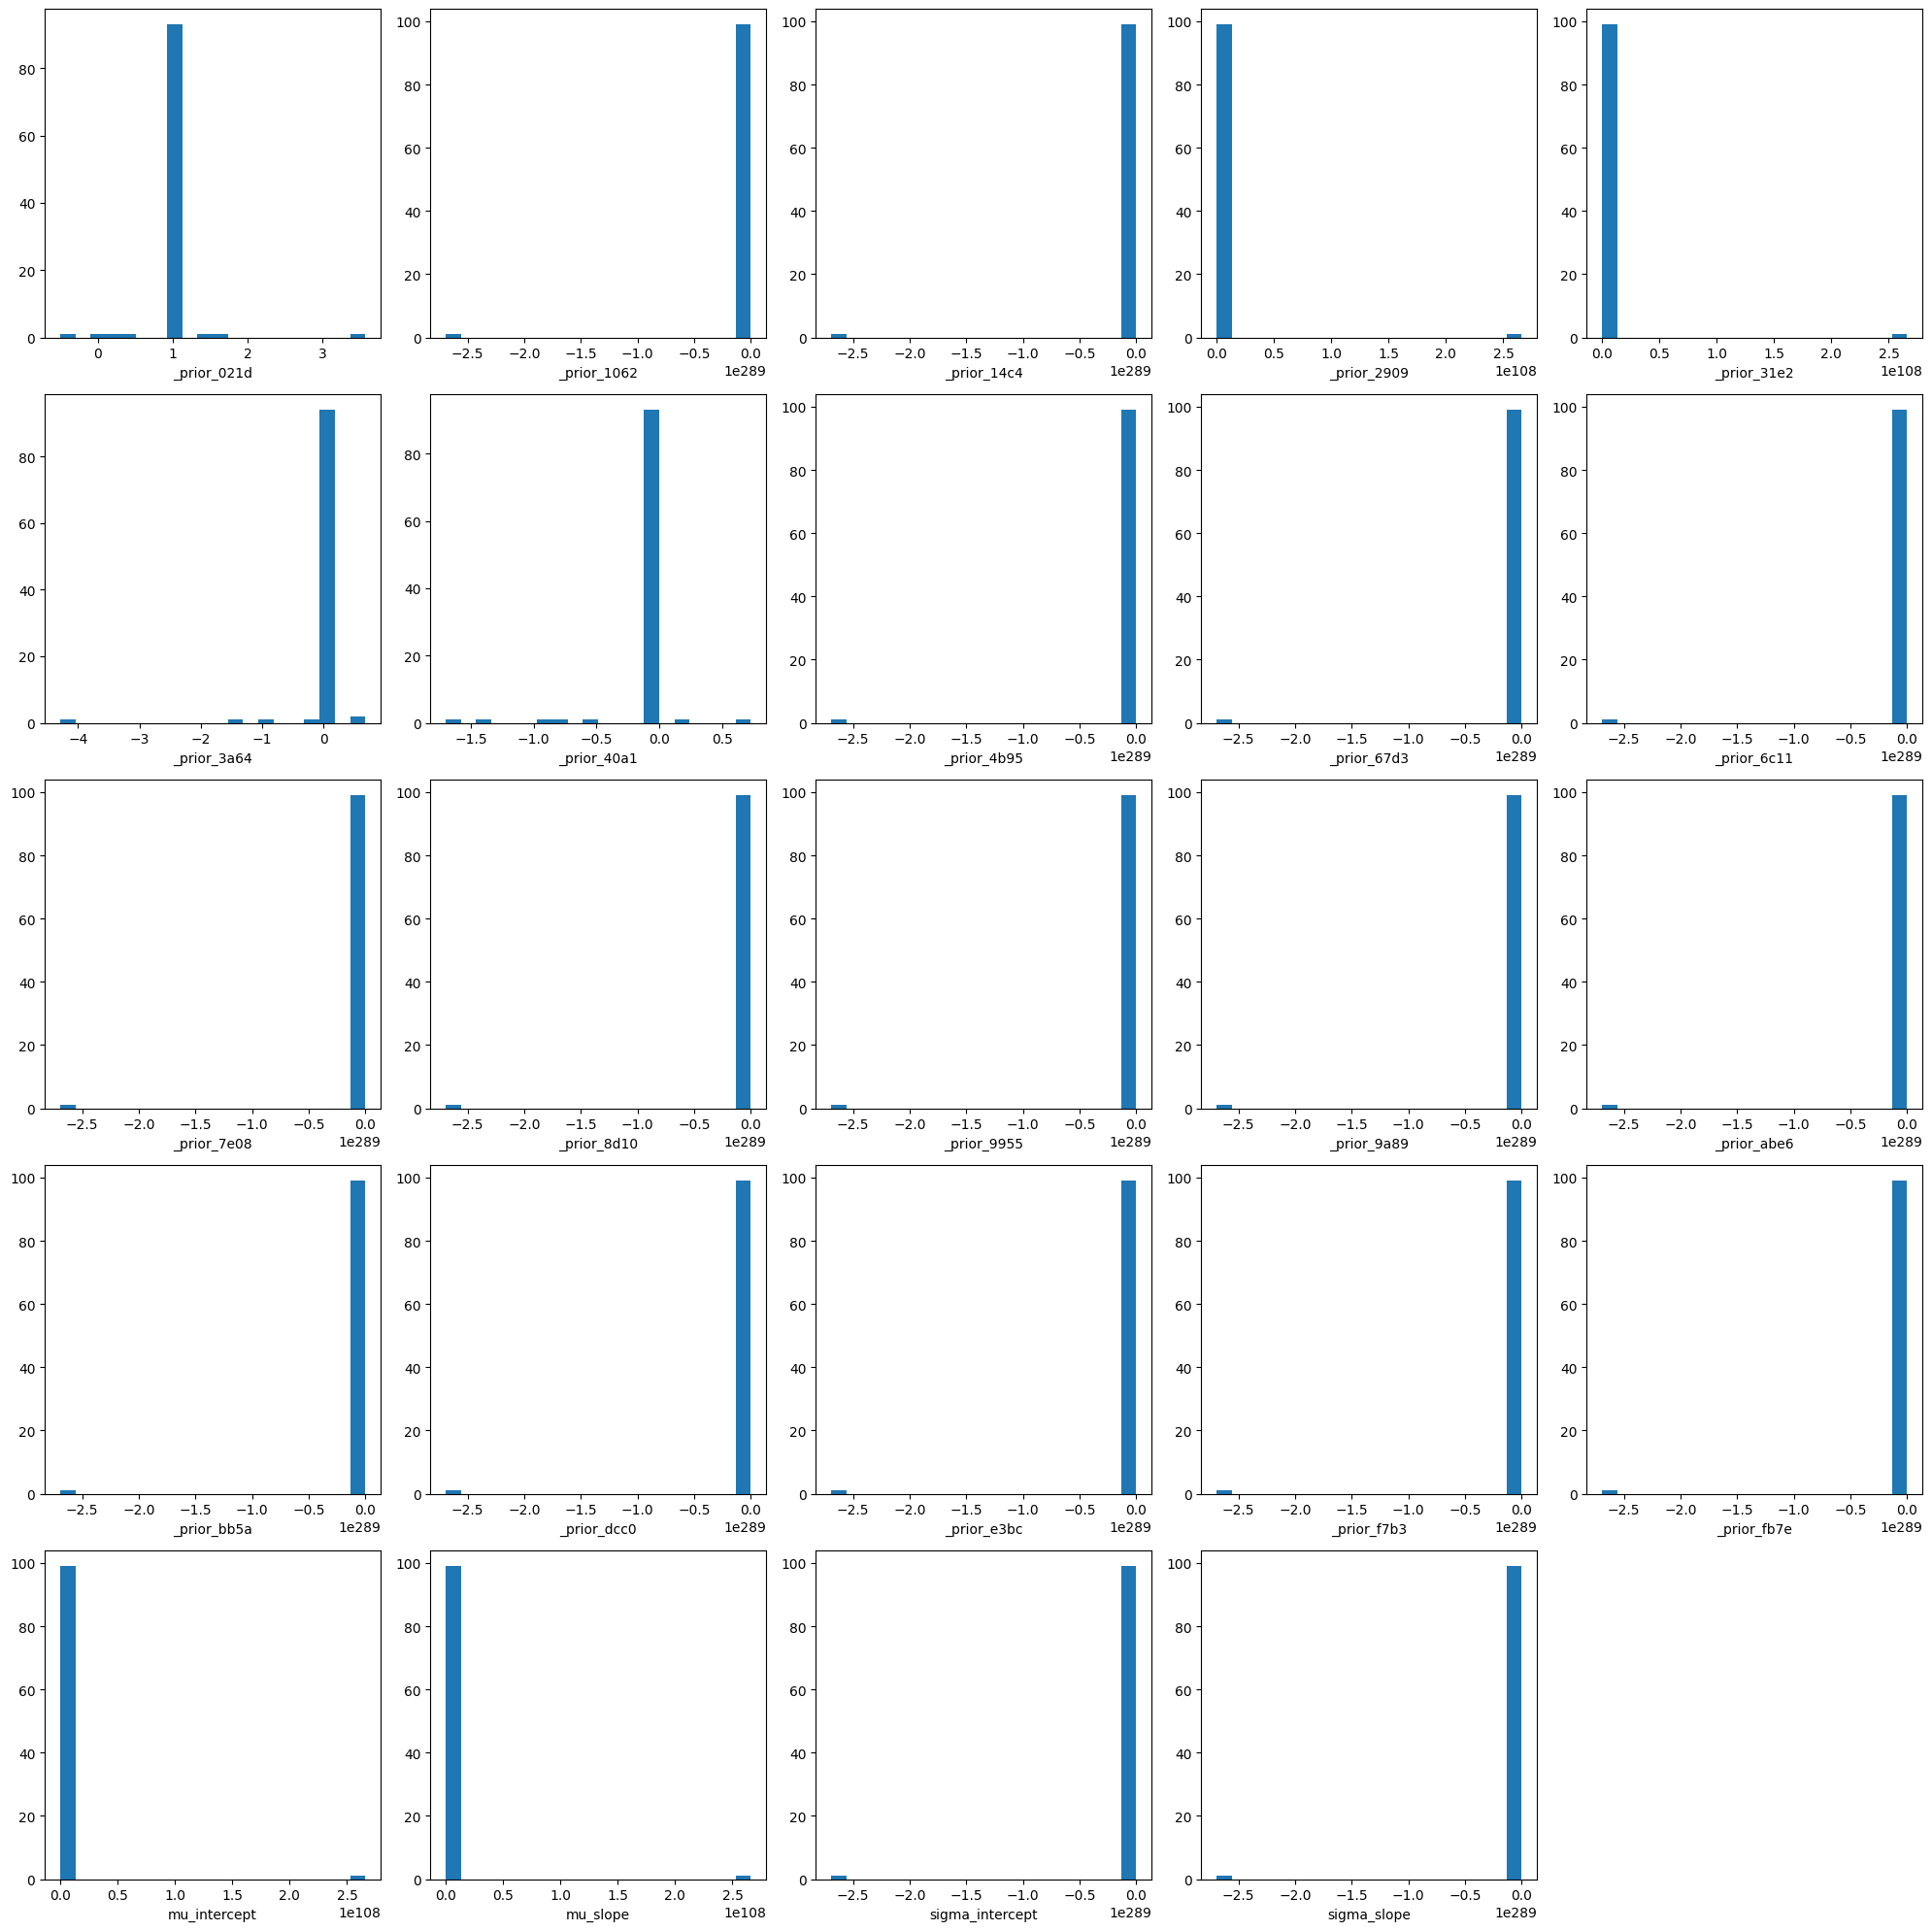

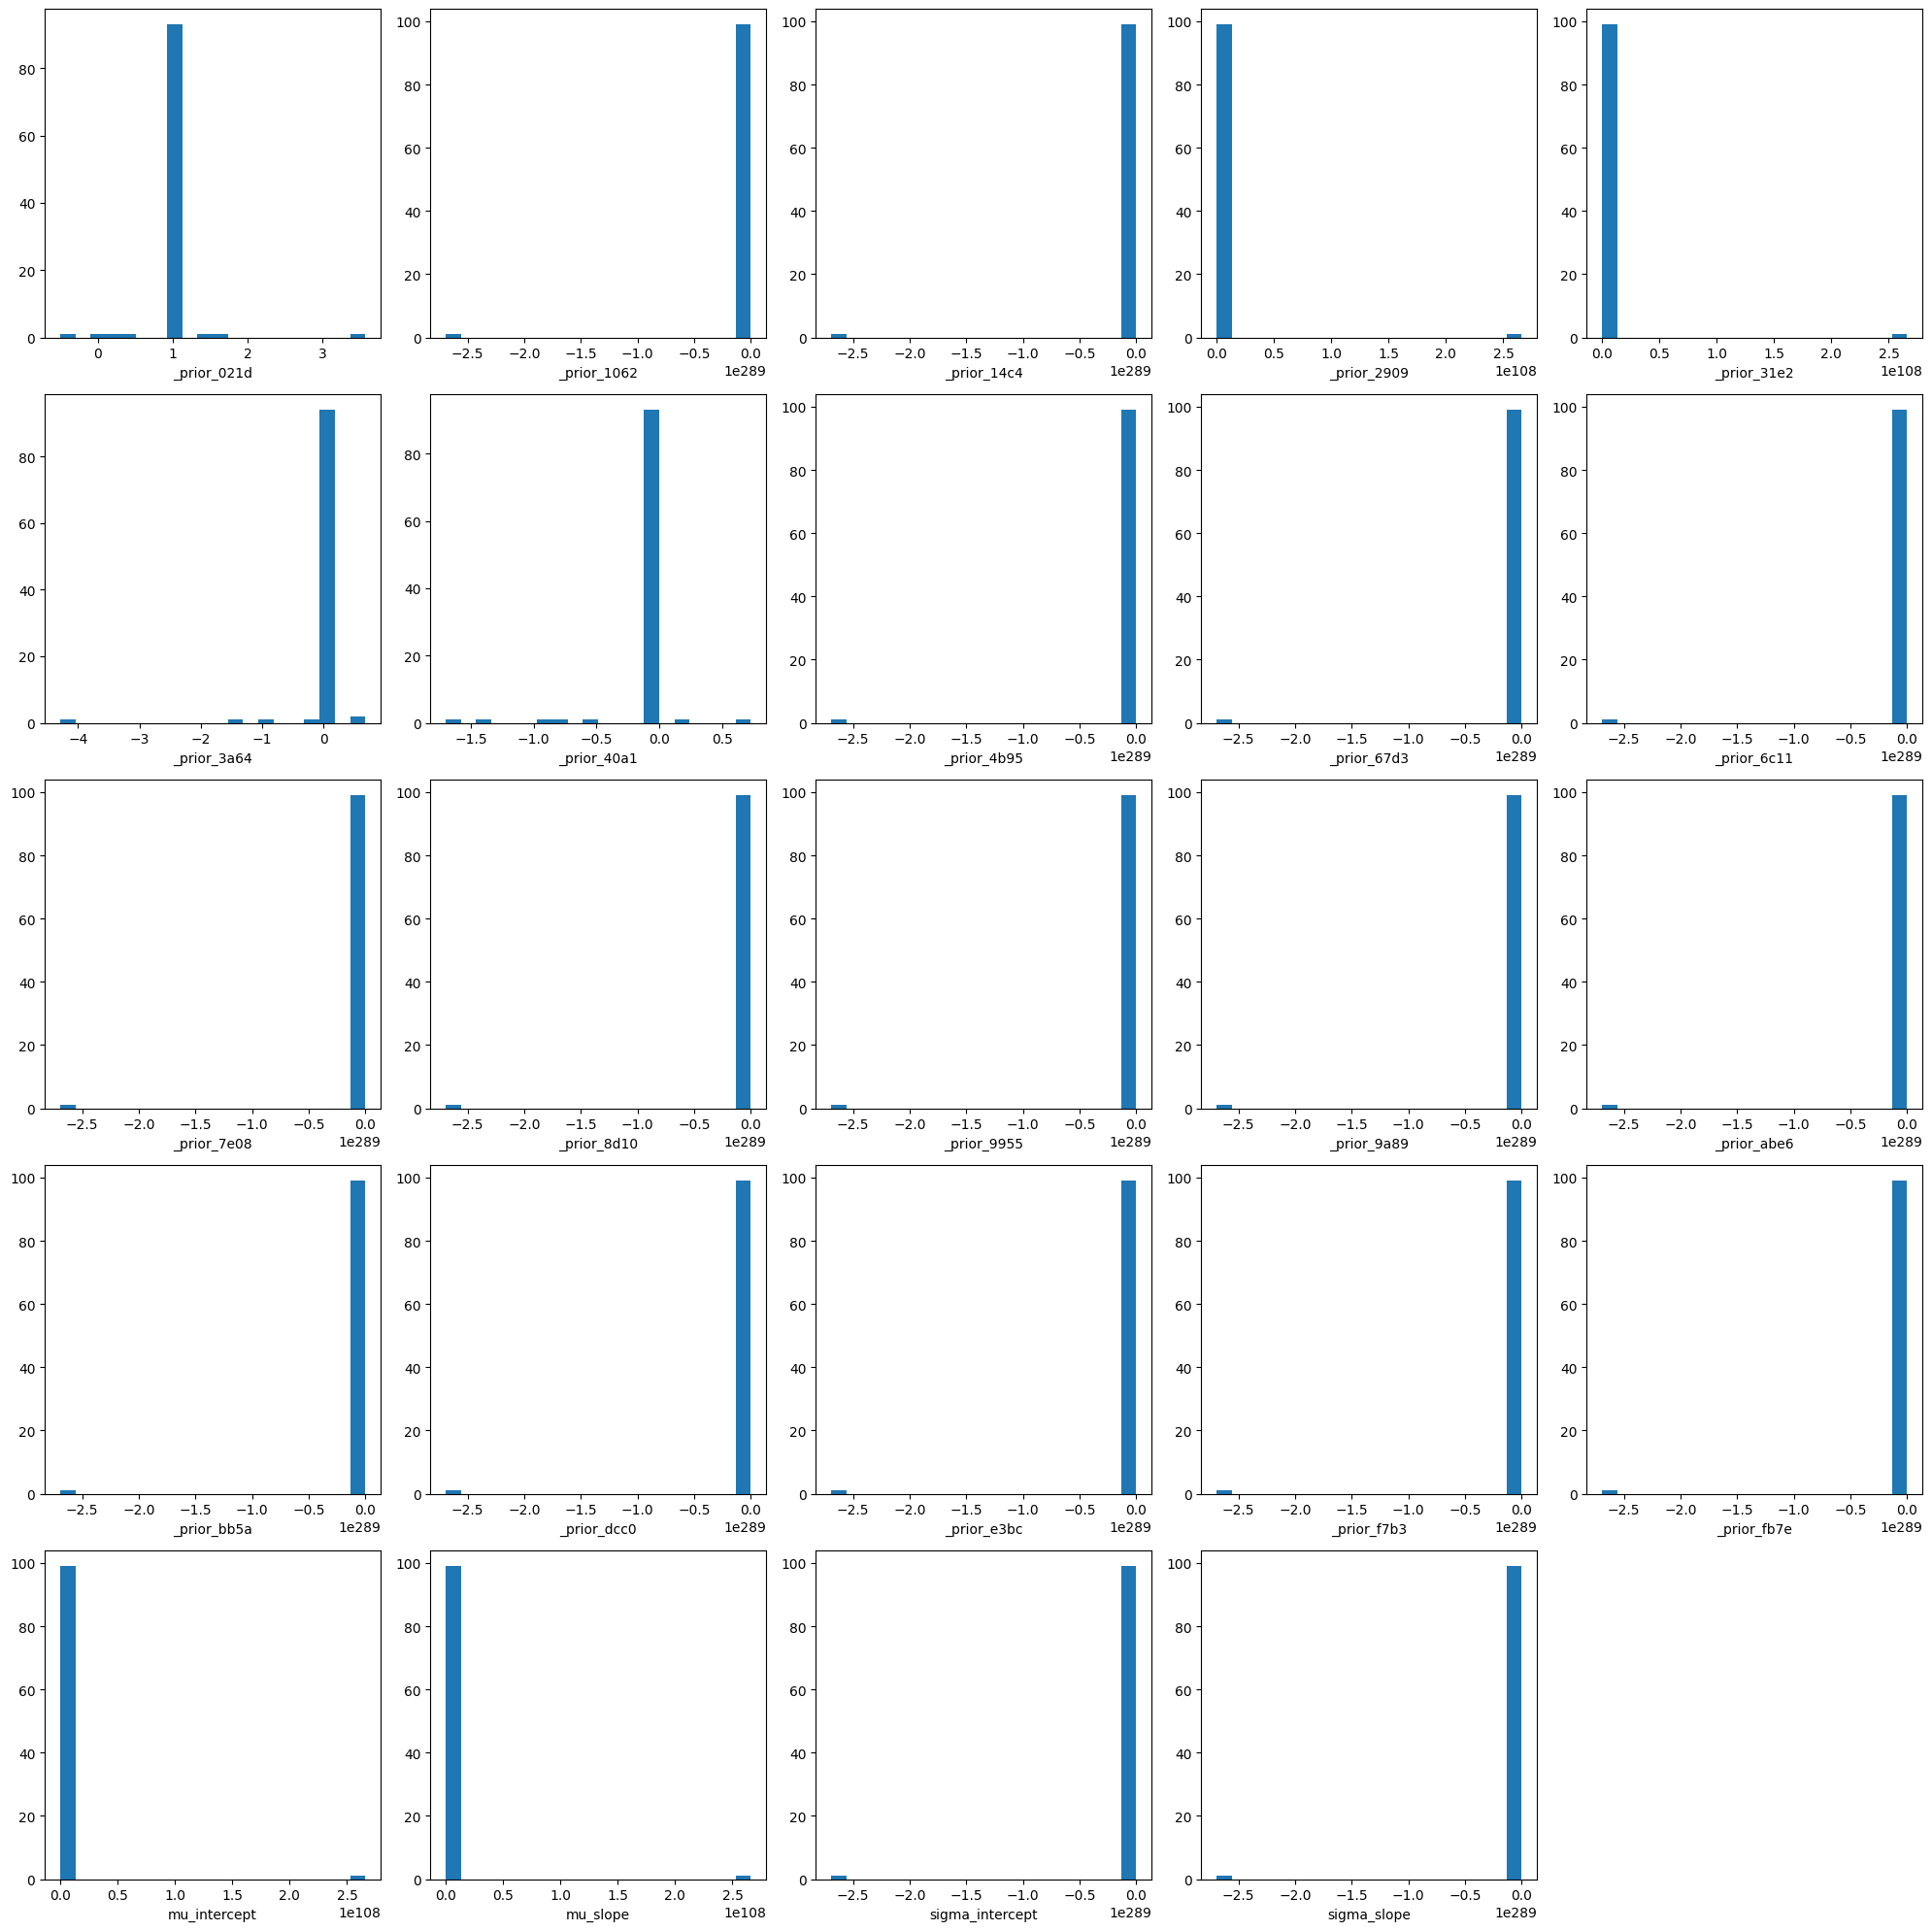

In [8]:
history = sampler.extract_result()
for plot_func in [history.plot_marginals, history.plot_pairs]:
    plot_func()
    plt.tight_layout()


In [9]:
parameter_estimates=[]
for name, values in history.samples.items():
    estimate = values.mean()  # Unweighted samples
    uncertainty = values.std()
    parameter_estimate = dict(
        name=name, estimate=estimate, uncertainty=uncertainty
    )
    parameter_estimates.append(parameter_estimate)
parameter_estimate_df = pd.DataFrame(parameter_estimates)
parameter_estimate_df

 /home/jbris/.cache/pypoetry/virtualenvs/likelihood-free-hyperpriors-test-on00DSHy-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning:overflow encountered in multiply


,name,estimate,uncertainty
0,_prior_021d,9.971752e-01,3.400074e-01
1,_prior_1062,-2.694672e+287,inf
2,_prior_14c4,-2.694672e+287,inf
3,_prior_2909,2.659066e+106,2.645737e+107
4,_prior_31e2,2.659066e+106,2.645737e+107
5,_prior_3a64,-5.899720e-02,4.733589e-01
6,_prior_40a1,-4.554656e-02,2.666564e-01
7,_prior_4b95,-2.694672e+287,inf
8,_prior_67d3,-2.694672e+287,inf
9,_prior_6c11,-2.694672e+287,inf


In [ ]:
# True hyperparameters
hyper_mu_intercept = 2.0    # Population-level intercept
hyper_sigma_intercept = 0.5 # Between-audience intercept variability
hyper_mu_slope = -0.03      # Population-level cost slope 
hyper_sigma_slope = 0.01    # Between-audience slope variability